In [1]:
# SPECIAL INSTRUCTIONS - TO RUN THIS CODE YOU MUST HAVE THE "diabetes_treatment_response - diabetes_treatment_response (1).csv" IN YOUR GOOGLE DRIVE, MAKE SURE IT IS NOT IN ANY FOLDERS.
#I have the majority of my Imports in this block of code but some blocks of code required me to import new libraries.
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns



In [2]:
#Make sure to run this code !!!
!pip install keras-tuner --upgrade


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.6 MB/s eta 0:00:00


In [3]:
# SPECIAL INSTRUCTIONS - TO RUN THIS CODE YOU MUST HAVE THE "diabetes_treatment_response - diabetes_treatment_response (1).csv" IN YOUR GOOGLE DRIVE, MAKE SURE IT IS NOT IN ANY FOLDERS AND IS JUST IN ROOT GOOGLE DRIVE.
# Loading the dataset with correct delimiter.
from google.colab import drive
import pandas as pd

drive.mount('/content/drive')

file_path = '/content/drive/My Drive/diabetes_treatment_response - diabetes_treatment_response (1).csv' #Here you can see the file path directory the csv should be, make sure your csv matches this file path aswell otherwise this code will fail.
df = pd.read_csv(file_path, delimiter=",")
print(df.head())


Mounted at /content/drive
   age gender   bmi  years_with_diabetes previous_medication  initial_hba1c  \
0   62      M  26.2                  6.7       Sulfonylureas            7.9   
1   53      F  28.9                  1.2       Sulfonylureas            8.4   
2   65      M  21.3                  3.3           Metformin            9.1   
3   78      F  23.1                  3.0                 NaN            8.9   
4   51      M  34.0                  7.8    DPP-4 inhibitors           10.4   

   blood_glucose  cholesterol exercise_frequency diet_type smoking_status  \
0          143.0          199              Light      Poor         Former   
1          249.0          251              Light      Poor        Current   
2          155.0          243              Light      Poor        Current   
3          178.0          157             Active      Good         Former   
4          202.0          173             Active      Poor         Former   

   treatment_adherence side_effects 

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
import numpy as np

#Here i am identifying the numerical and categorical columns
numerical_cols = df.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_cols = df.select_dtypes(include=["object"]).columns.tolist()

#Removing target variable from numerical columns
target_variable = "hba1c_improvement"
numerical_cols.remove(target_variable)

#OUTLIER HANDLING - IQR METHOD - this is a statistical technique used to detect/ handle outliers.
Q1 = df[numerical_cols].quantile(0.25)
Q3 = df[numerical_cols].quantile(0.75)
IQR = Q3 - Q1

#Defining outlier thresholds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Removing the outliers (values outside the IQR range)
df = df[~((df[numerical_cols] < lower_bound) | (df[numerical_cols] > upper_bound)).any(axis=1)]

#FEATURE SELECTION - REMOVE HIGHLY CORRELATED FEATURES #
corr_matrix = df[numerical_cols].corr().abs()
upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

#here im dropping features with correlation > 0.85
high_corr_features = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.85)]
df = df.drop(columns=high_corr_features)

#Updating numerical columns after feature removal.
numerical_cols = [col for col in numerical_cols if col not in high_corr_features]

### SPLIT DATA ###
X = df.drop(columns=[target_variable])
y = df[target_variable]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# PREPROCESSING PIPELINE
# Numerical transformer: imputation and scaling
num_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),  #Filling missing values with median
    ("scaler", StandardScaler())  #Normalising the numerical features
])

# Categorical transformer: imputation and one-hot encoding
cat_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),  # Fill missing values with mode
    ("encoder", OneHotEncoder(handle_unknown="ignore"))  # One-hot encode categorical features
])

# Combine transformers
preprocessor = ColumnTransformer(transformers=[
    ("num", num_transformer, numerical_cols),
    ("cat", cat_transformer, categorical_cols)
])

# Apply preprocessing to training and test sets
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print("X_train_processed shape:", X_train_processed.shape)
print("X_test_processed shape:", X_test_processed.shape)



X_train_processed shape: (780, 28)
X_test_processed shape: (195, 28)


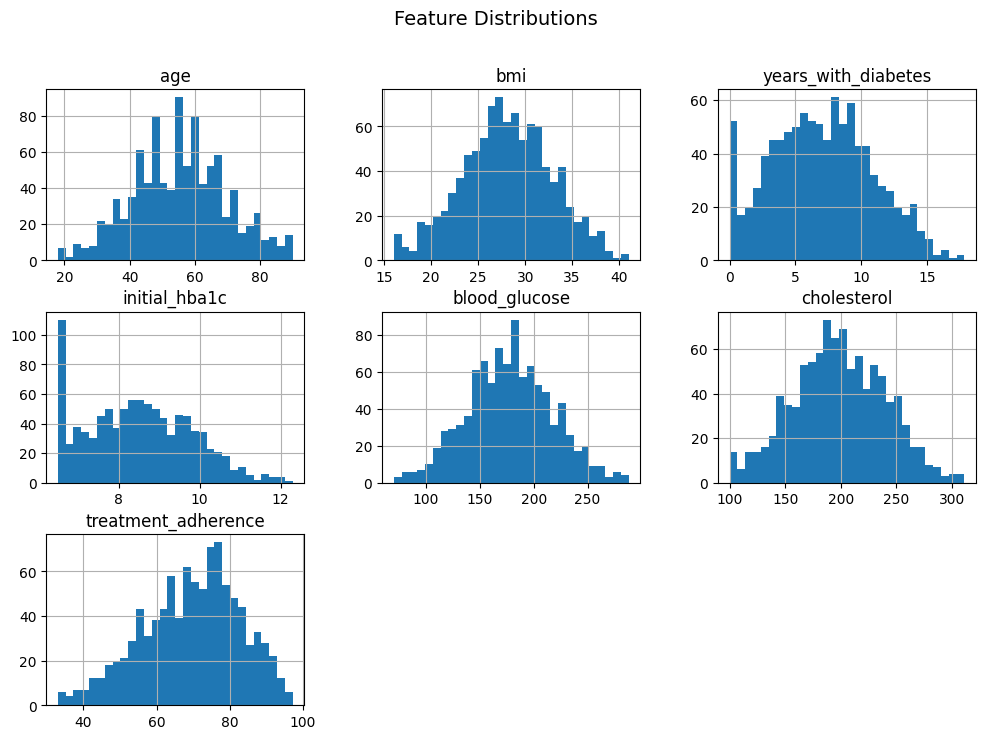

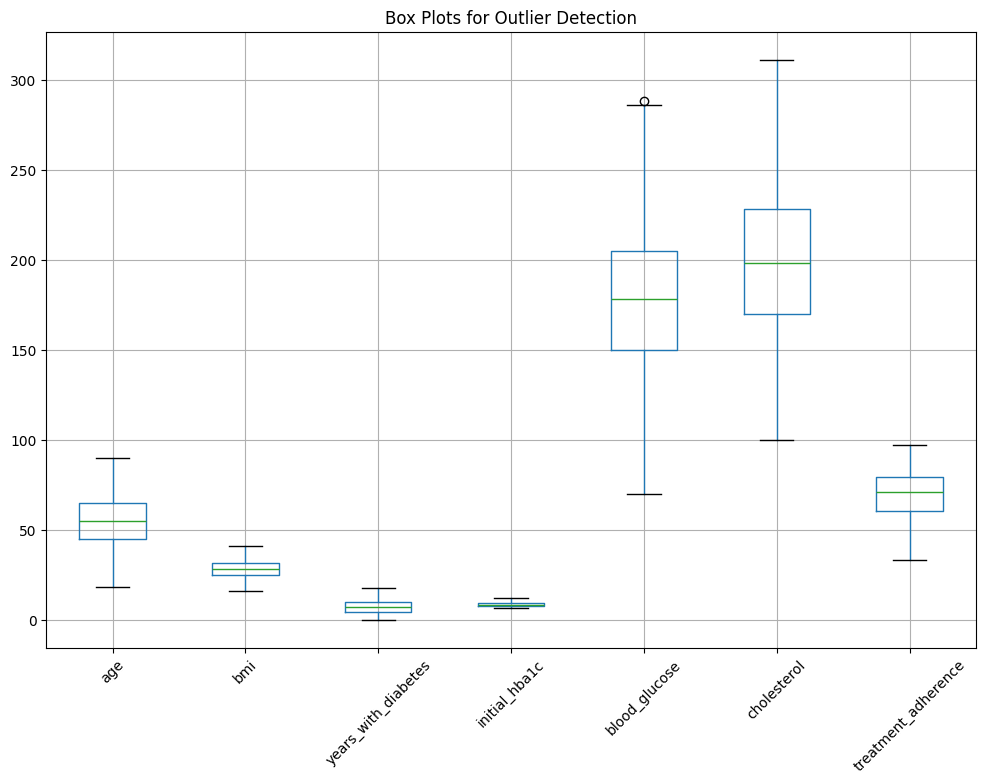

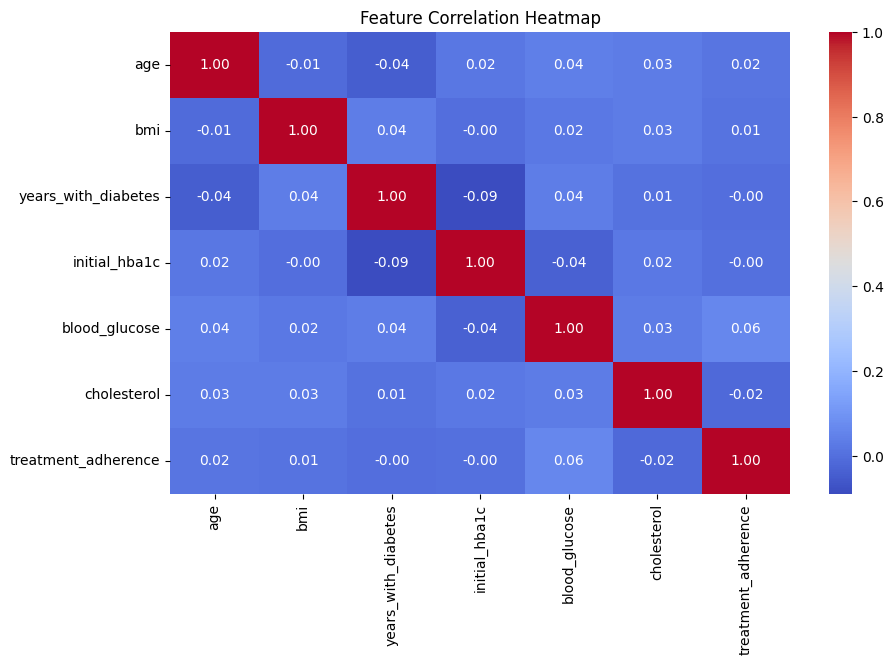

In [ ]:
#This block of code is just to visualise the data after preprrocessing and before any model development, this will help me understand more about the data.
# Histograms for numerical features

df[numerical_cols].hist(figsize=(12, 8), bins=30)
plt.suptitle("Feature Distributions", fontsize=14)
plt.show()

# Box plots for outlier detection
plt.figure(figsize=(12, 8))
df[numerical_cols].boxplot(rot=45)
plt.title("Box Plots for Outlier Detection")
plt.show()

# Correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df[numerical_cols].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

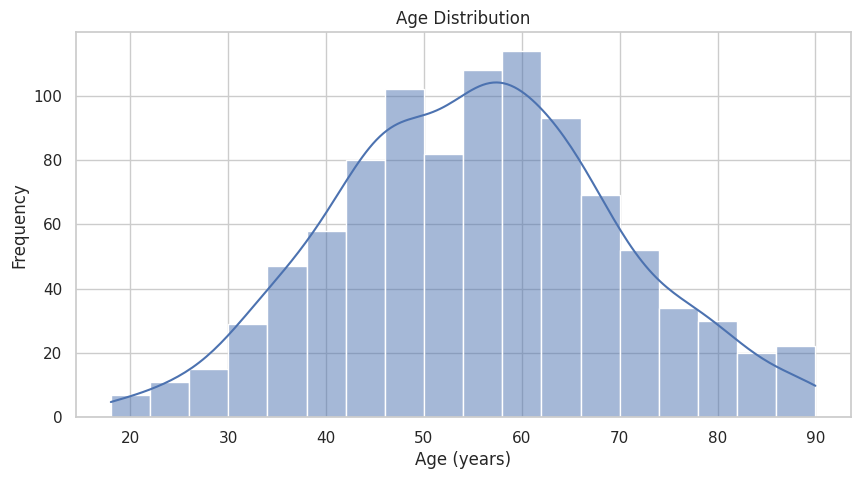

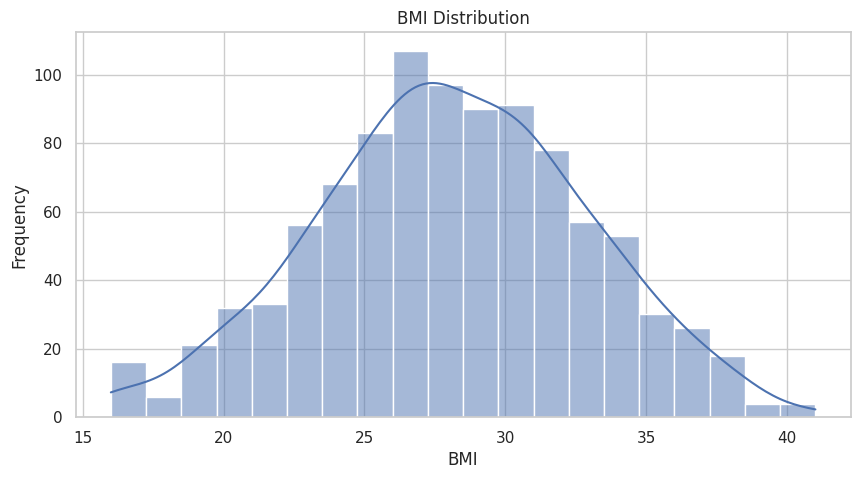

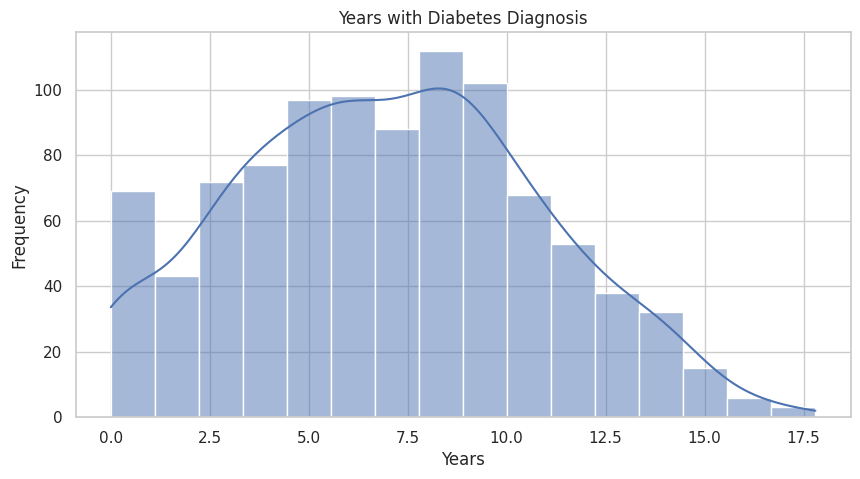

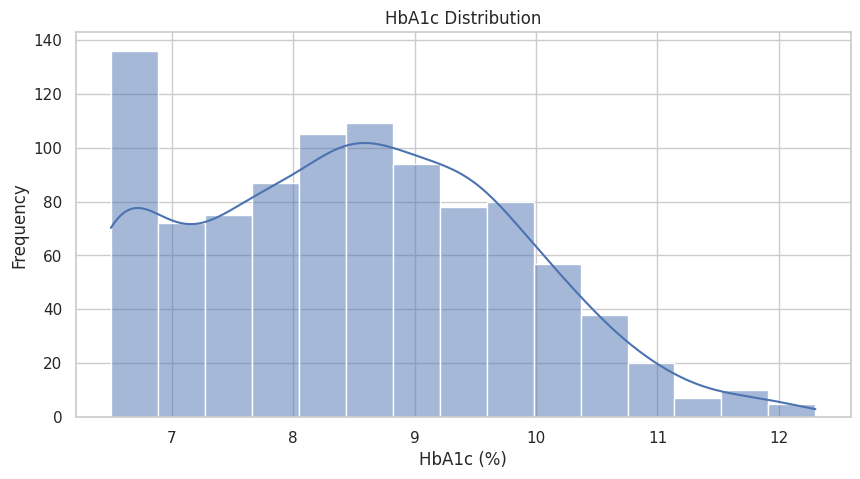

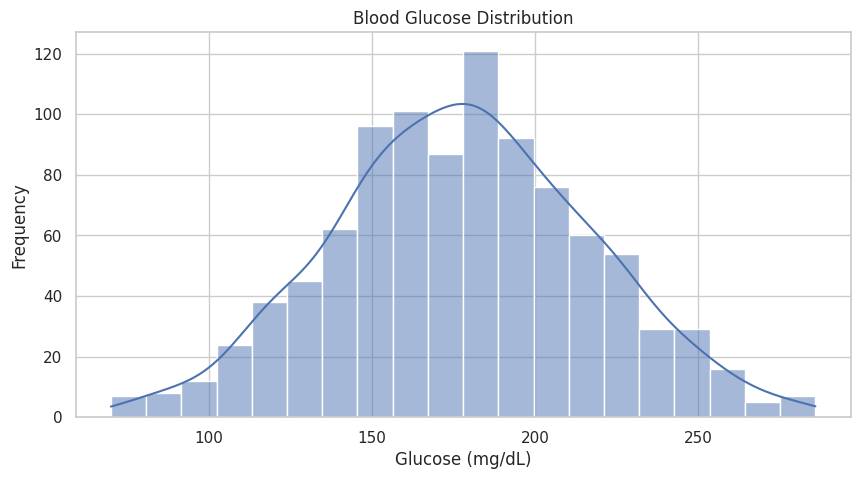

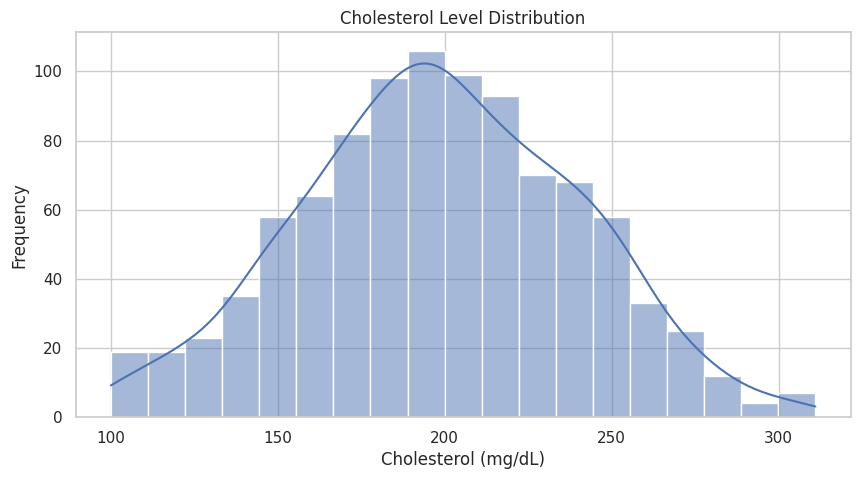

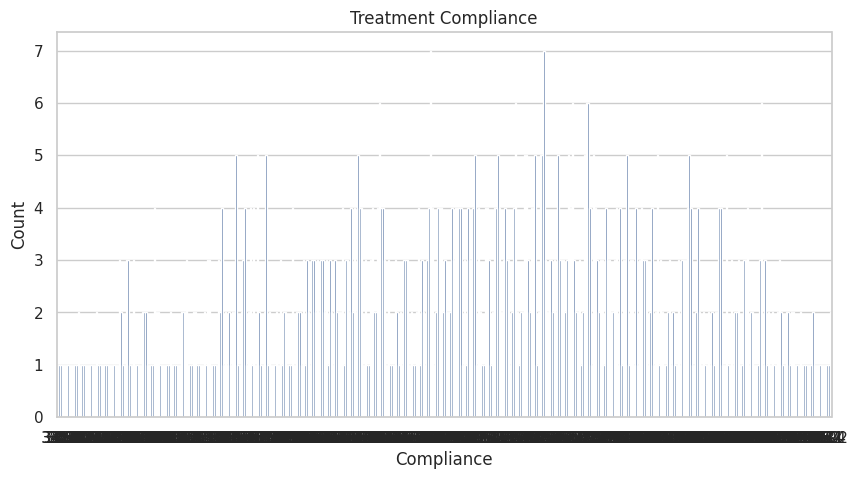

Summary Statistics:
              age         bmi  years_with_diabetes  initial_hba1c  \
count  973.000000  970.000000           973.000000     973.000000   
mean    55.267215   28.072062             7.020863       8.494861   
std     14.423722    4.796371             3.826901       1.310285   
min     18.000000   16.000000             0.000000       6.500000   
25%     45.000000   24.900000             4.100000       7.500000   
50%     55.000000   28.000000             6.900000       8.500000   
75%     65.000000   31.400000             9.700000       9.500000   
max     90.000000   41.000000            17.800000      12.300000   

       blood_glucose  cholesterol  
count     969.000000   973.000000  
mean      177.728586   198.384378  
std        39.689675    41.277644  
min        70.000000   100.000000  
25%       150.000000   170.000000  
50%       178.000000   198.000000  
75%       205.000000   228.000000  
max       286.000000   311.000000  


In [19]:
sns.set(style="whitegrid")

def plot_distribution(column, title, xlabel):
    plt.figure(figsize=(10, 5))
    sns.histplot(df[column].dropna(), kde=True)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Frequency')
    plt.show()

plot_distribution('age', "Age Distribution", "Age (years)")
plot_distribution('bmi', "BMI Distribution", "BMI")
plot_distribution('years_with_diabetes', "Years with Diabetes Diagnosis", "Years")
plot_distribution('initial_hba1c', "HbA1c Distribution", "HbA1c (%)")
plot_distribution('blood_glucose', "Blood Glucose Distribution", "Glucose (mg/dL)")
plot_distribution('cholesterol', "Cholesterol Level Distribution", "Cholesterol (mg/dL)")

plt.figure(figsize=(10, 5))
sns.countplot(x=df['treatment_adherence'].dropna())
plt.title("Treatment Compliance")
plt.xlabel("Compliance")
plt.ylabel("Count")
plt.show()

print("Summary Statistics:")
print(df[['age', 'bmi', 'years_with_diabetes', 'initial_hba1c', 'blood_glucose', 'cholesterol']].describe())


In [ ]:
# LINEAR REGRESSION MODEL
#Here i am defining hyperparameter grid for Ridge Regression (since LinearRegression has no parameters)
param_grid = {'alpha': np.logspace(-4, 4, 10)}  #Trying different values for alpha

# Create Ridge Regression model (Linear Regression with regularization)
ridge = Ridge()

#Performing a Grid Search with 10-Fold Cross-Validation. this is a resampling technique used to evaluate the perfomance of machine learning models.
grid_search = GridSearchCV(ridge, param_grid, cv=10, scoring='r2', n_jobs=-1)
grid_search.fit(X_train_processed, y_train)

# Best Model and Hyperparameter.
best_model = grid_search.best_estimator_
best_alpha = grid_search.best_params_['alpha']

# Predictions using the best model.
y_pred_best = best_model.predict(X_test_processed)

#My Evaluation Metrics..
mse_best = mean_squared_error(y_test, y_pred_best)
rmse_best = np.sqrt(mse_best)
mae_best = mean_absolute_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)

print(f"Best Alpha: {best_alpha}")
print(f"Mean Squared Error (MSE): {mse_best:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_best:.2f}")
print(f"Mean Absolute Error (MAE): {mae_best:.2f}")
print(f"R-squared (R²): {r2_best:.2f}")


#Extracting feature names after preprocessing
feature_names = preprocessor.get_feature_names_out()

#Get feature importance (absolute coefficient values)
feature_importance = pd.Series(np.abs(best_model.coef_), index=feature_names)

#Sorting by importance
feature_importance = feature_importance.sort_values(ascending=False)

# Display feature importance
print(feature_importance)

# FAIRNESS AND BIAS ANALYSIS

# Create age range bins
df["age_range"] = pd.cut(df["age"], bins=[0, 18, 30, 50, 65, 100], labels=["0-18", "19-30", "31-50", "51-65", "65+"])

def assess_fairness(df, model, preprocessor, target_variable, demographic_feature):
    unique_groups = df[demographic_feature].unique()
    fairness_results = {}

    for group in unique_groups:
        group_df = df[df[demographic_feature] == group]
        if group_df.shape[0] < 10:  # Ensure there's enough data.
            continue

        X_group = group_df.drop(columns=[target_variable])
        y_group = group_df[target_variable]
        X_group_processed = preprocessor.transform(X_group)
        y_pred_group = model.predict(X_group_processed)

        mae_group = mean_absolute_error(y_group, y_pred_group)
        fairness_results[group] = mae_group

    return fairness_results

#here i am Defining demographic features for fairness analysis
demographic_features = ["gender", "race", "age_range"]  # Adjust based on dataset

for feature in demographic_features:
    if feature in df.columns:
        fairness_metrics = assess_fairness(df, best_model, preprocessor, target_variable, feature)
        print(f"Fairness Analysis for {feature}:")
        for group, mae in fairness_metrics.items():
            print(f"  {group}: MAE = {mae:.2f}")



Best Alpha: 21.54434690031882
Mean Squared Error (MSE): 0.03
Root Mean Squared Error (RMSE): 0.18
Mean Absolute Error (MAE): 0.14
R-squared (R²): 0.59
num__initial_hba1c                           0.172881
cat__side_effects_Mild                       0.087790
cat__side_effects_Severe                     0.066144
num__treatment_adherence                     0.050850
cat__exercise_frequency_Sedentary            0.038822
cat__exercise_frequency_Active               0.031137
cat__side_effects_Moderate                   0.021646
cat__diet_type_Excellent                     0.016529
cat__diet_type_Average                       0.014422
cat__smoking_status_Former                   0.013311
cat__diet_type_Poor                          0.013013
cat__previous_medication_Metformin'          0.011040
cat__diet_type_Good                          0.010906
cat__exercise_frequency_Moderate             0.009295
cat__previous_medication_Metformin           0.008359
cat__smoking_status_Never              

In [ ]:
# RANDOM FOREST MODEL

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

#Checking if the target variable is binary or continuous
if df["hba1c_improvement"].nunique() == 2:
    # Classification Task
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    is_classification = True
else:
    # Regression Task
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    is_classification = False

#Spliting data into features and target
X = df.drop(columns=["hba1c_improvement"])
y = df["hba1c_improvement"]

# Train-test split.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Apply the preprocessing pipeline.
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

#Training the model below
model.fit(X_train_processed, y_train)

#This will create the predictions
y_pred = model.predict(X_test_processed)

# Evaluation Metrics.
if is_classification:
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average="binary")
    recall = recall_score(y_test, y_pred, average="binary")
    f1 = f1_score(y_test, y_pred, average="binary")

    # Compute specificity from confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    specificity = tn / (tn + fp)

    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print(f"Specificity: {specificity:.2f}")

else:
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Adjusted R-squared
    n, p = X_test_processed.shape
    adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"R-squared (R²): {r2:.2f}")
    print(f"Adjusted R-squared: {adj_r2:.2f}")

# FEATURE IMPORTANCE
feature_names = preprocessor.get_feature_names_out()
feature_importance = pd.Series(model.feature_importances_, index=feature_names).sort_values(ascending=False)
print("Feature Importance:")
print(feature_importance)

# FAIRNESS AND BIAS ANALYSIS
def assess_fairness(df, model, preprocessor, target_variable, demographic_feature):
    unique_groups = df[demographic_feature].unique()
    fairness_results = {}

    for group in unique_groups:
        group_df = df[df[demographic_feature] == group]
        if group_df.shape[0] < 10:
            continue

        X_group = group_df.drop(columns=[target_variable])
        y_group = group_df[target_variable]
        X_group_processed = preprocessor.transform(X_group)
        y_pred_group = model.predict(X_group_processed)

        mae_group = mean_absolute_error(y_group, y_pred_group)
        fairness_results[group] = mae_group

    return fairness_results

#Ensure age is binned into categories.
df["age_range"] = pd.cut(df["age"], bins=[0, 18, 30, 50, 65, 100], labels=["0-18", "19-30", "31-50", "51-65", "65+"])

# Define demographic features for fairness analysis
demographic_features = ["gender", "race", "age_range"]

for feature in demographic_features:
    if feature in df.columns:
        fairness_metrics = assess_fairness(df, model, preprocessor, "hba1c_improvement", feature)
        print(f"Fairness Analysis for {feature}:")
        for group, mae in fairness_metrics.items():
            print(f"  {group}: MAE = {mae:.2f}")


Mean Squared Error (MSE): 0.03
Root Mean Squared Error (RMSE): 0.19
Mean Absolute Error (MAE): 0.15
R-squared (R²): 0.57
Adjusted R-squared: 0.50
Feature Importance:
num__initial_hba1c                           0.496092
num__treatment_adherence                     0.113304
num__cholesterol                             0.055999
num__age                                     0.052279
num__blood_glucose                           0.052014
num__bmi                                     0.049541
num__years_with_diabetes                     0.046668
cat__side_effects_Mild                       0.027111
cat__side_effects_Severe                     0.024292
cat__exercise_frequency_Sedentary            0.008275
cat__diet_type_Good                          0.006883
cat__exercise_frequency_Active               0.006224
cat__diet_type_Average                       0.005827
cat__smoking_status_Never                    0.005492
cat__smoking_status_Former                   0.005427
cat__diet_type_Excellent

In [ ]:
#TUNED SVM CODE
#Usually takes 50 seconds to a minute to run this code.
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
import numpy as np

#Define the hyperparameter search space
param_grid = {
    "C": [0.1, 1, 10, 50, 100],  # Regularisation strength
    "epsilon": [0.01, 0.05, 0.1, 0.2],  #Epsilon-insensitive loss function
    "gamma": ["scale", "auto", 0.001, 0.01, 0.1, 1]  #Kernel coefficient
}

#Doing a grid Search with Cross-Validation (5-Fold) Sometimes 10 fold can be too resource intensive and make the code take a long time to run so in these cases i use 5 fold.
svr = SVR(kernel="rbf")  #Using radial basis function kernel
grid_search = GridSearchCV(svr, param_grid, cv=5, scoring="r2", n_jobs=-1, verbose=2)
grid_search.fit(X_train_processed, y_train)

#Best model from tuning
best_svr = grid_search.best_estimator_
best_params = grid_search.best_params_

# predictions using the best model
y_pred_best = best_svr.predict(X_test_processed)

#My Evaluation Metrics
mse = mean_squared_error(y_test, y_pred_best)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred_best)
r2 = r2_score(y_test, y_pred_best)

# Adjusted R-squared.
n, p = X_test_processed.shape
adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

print(f"Best Parameters: {best_params}")
print("SVM Regression Results (Tuned Model):")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R²): {r2:.4f}")
print(f"Adjusted R-squared: {adj_r2:.4f}")


Fitting 5 folds for each of 120 candidates, totalling 600 fits
Best Parameters: {'C': 1, 'epsilon': 0.1, 'gamma': 0.01}
SVM Regression Results (Tuned Model):
Mean Squared Error (MSE): 0.0333
Root Mean Squared Error (RMSE): 0.1825
Mean Absolute Error (MAE): 0.1456
R-squared (R²): 0.5824
Adjusted R-squared: 0.5120


In [ ]:
# SUPPORT VECTOR MACHINE MODEL
#Usually takes 50 seconds to a minute to run this code.

from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
import numpy as np
import pandas as pd
from sklearn.inspection import permutation_importance

#Defining hyperparameter search space
param_grid = {
    "C": [0.1, 1, 10, 50, 100],  # Regularisation strength.
    "epsilon": [0.01, 0.05, 0.1, 0.2],  #Epsilon-insensitive loss function.
    "gamma": ["scale", "auto", 0.001, 0.01, 0.1, 1]  #Kernel coefficient
}

#grid Search with Cross-Validation (5-Fold)
svr = SVR(kernel="rbf")  # Using radial basis function kernel.
grid_search = GridSearchCV(svr, param_grid, cv=5, scoring="r2", n_jobs=-1, verbose=2)
grid_search.fit(X_train_processed, y_train)

#Best model from tuning
best_svr = grid_search.best_estimator_
best_params = grid_search.best_params_

#creating predictions using the best model
y_pred_best = best_svr.predict(X_test_processed)

#Evaluation Metrics
mse = mean_squared_error(y_test, y_pred_best)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred_best)
r2 = r2_score(y_test, y_pred_best)

#Adjusted R-squared
n, p = X_test_processed.shape
adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

print(f"Best Parameters: {best_params}")
print("SVM Regression Results (Tuned Model):")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R²): {r2:.4f}")
print(f"Adjusted R-squared: {adj_r2:.4f}")

# FEATURE IMPORTANCE (PERMUTATION IMPORTANCE)
#I've replaced the SHAP-based feature importance with Permutation importance which works well with SVR
perm_importance = permutation_importance(best_svr, X_test_processed, y_test, n_repeats=10, random_state=42)
feature_importance = pd.Series(perm_importance.importances_mean, index=preprocessor.get_feature_names_out())
feature_importance = feature_importance.sort_values(ascending=False)

print("Feature Importance (Permutation Importance):")
print(feature_importance)

# FAIRNESS AND BIAS ANALYSIS
def assess_fairness(df, model, preprocessor, target_variable, demographic_feature):
    unique_groups = df[demographic_feature].unique()
    fairness_results = {}

    for group in unique_groups:
        group_df = df[df[demographic_feature] == group]
        if group_df.shape[0] < 10:
            continue

        X_group = group_df.drop(columns=[target_variable])
        y_group = group_df[target_variable]
        X_group_processed = preprocessor.transform(X_group)
        y_pred_group = model.predict(X_group_processed)

        mae_group = mean_absolute_error(y_group, y_pred_group)
        fairness_results[group] = mae_group

    return fairness_results

#Ensure age is binned into categories like other models.
df["age_range"] = pd.cut(df["age"], bins=[0, 18, 30, 50, 65, 100], labels=["0-18", "19-30", "31-50", "51-65", "65+"])

#Defining demographic features for fairness analysis
demographic_features = ["gender", "race", "age_range"]

for feature in demographic_features:
    if feature in df.columns:
        fairness_metrics = assess_fairness(df, best_svr, preprocessor, "hba1c_improvement", feature)
        print(f"Fairness Analysis for {feature}:")
        for group, mae in fairness_metrics.items():
            print(f"  {group}: MAE = {mae:.2f}")



Fitting 5 folds for each of 120 candidates, totalling 600 fits
Best Parameters: {'C': 1, 'epsilon': 0.1, 'gamma': 0.01}
SVM Regression Results (Tuned Model):
Mean Squared Error (MSE): 0.0333
Root Mean Squared Error (RMSE): 0.1825
Mean Absolute Error (MAE): 0.1456
R-squared (R²): 0.5824
Adjusted R-squared: 0.5120
Feature Importance (Permutation Importance):
num__initial_hba1c                           0.848314
num__treatment_adherence                     0.095251
cat__side_effects_Mild                       0.030191
cat__side_effects_Severe                     0.006283
cat__exercise_frequency_Sedentary            0.005588
cat__exercise_frequency_Active               0.005167
cat__diet_type_Excellent                     0.003570
num__cholesterol                             0.002787
num__age                                     0.002686
cat__smoking_status_Former                   0.002495
cat__side_effects_Moderate                   0.002329
cat__diet_type_Poor                          0.

In [ ]:
#GRADIENT BOOSTING MODEL

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.inspection import permutation_importance
import numpy as np
import pandas as pd


# Defining my model below.
model = GradientBoostingRegressor(random_state=42)

# create the hyperparameter search space
param_dist = {
    "n_estimators": [100, 150, 200, 250],
    "learning_rate": [0.05, 0.1, 0.2],
    "max_depth": [3, 5, 7],
    "min_samples_split": [5, 10],
    "min_samples_leaf": [2, 4],
    "subsample": [0.8, 0.9, 1.0],
}

#Randomised Search with 3-Fold Cross-Validation (Again another change to validation to cut down on run time)
random_search = RandomizedSearchCV(
    model,
    param_distributions=param_dist,
    n_iter=15,
    cv=3,
    scoring="r2",
    random_state=42,
    n_jobs=-1,
    verbose=2
)

#Fit Randomised Search on processed training data
random_search.fit(X_train_processed, y_train)

# Best model and parameters.
best_model = random_search.best_estimator_
best_params = random_search.best_params_

# predictions using the best model
y_pred_best = best_model.predict(X_test_processed)

#Evaluation Metrics.
mse = mean_squared_error(y_test, y_pred_best)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred_best)
r2 = r2_score(y_test, y_pred_best)

# Adjusted R-squared
n, p = X_test_processed.shape
adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

print(f"Best Parameters: {best_params}")
print("Gradient Boosting Regression Results (Tuned Model):")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R²): {r2:.4f}")
print(f"Adjusted R-squared: {adj_r2:.4f}")

# FEATURE IMPORTANCE (PERMUTATION IMPORTANCE)
perm_importance = permutation_importance(best_model, X_test_processed, y_test, n_repeats=10, random_state=42)
feature_importance = pd.Series(perm_importance.importances_mean, index=preprocessor.get_feature_names_out())
feature_importance = feature_importance.sort_values(ascending=False)

print("Feature Importance (Permutation Importance):")
print(feature_importance)

#FAIRNESS AND BIAS ANALYSIS
def assess_fairness(df, model, preprocessor, target_variable, demographic_feature):
    unique_groups = df[demographic_feature].unique()
    fairness_results = {}

    for group in unique_groups:
        group_df = df[df[demographic_feature] == group]
        if group_df.shape[0] < 10:  #check to see if there's enough data
            continue

        X_group = group_df.drop(columns=[target_variable])
        y_group = group_df[target_variable]
        X_group_processed = preprocessor.transform(X_group)
        y_pred_group = model.predict(X_group_processed)

        mae_group = mean_absolute_error(y_group, y_pred_group)
        fairness_results[group] = mae_group

    return fairness_results

#Ensuring age is binned into categories
df["age_range"] = pd.cut(df["age"], bins=[0, 18, 30, 50, 65, 100], labels=["0-18", "19-30", "31-50", "51-65", "65+"])

#Define demographic features for fairness analysis
demographic_features = ["gender", "race", "age_range"]

for feature in demographic_features:
    if feature in df.columns:
        fairness_metrics = assess_fairness(df, best_model, preprocessor, "hba1c_improvement", feature)
        print(f"Fairness Analysis for {feature}:")
        for group, mae in fairness_metrics.items():
            print(f"  {group}: MAE = {mae:.2f}")


Fitting 3 folds for each of 15 candidates, totalling 45 fits
Best Parameters: {'subsample': 0.8, 'n_estimators': 150, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_depth': 3, 'learning_rate': 0.05}
Gradient Boosting Regression Results (Tuned Model):
Mean Squared Error (MSE): 0.0340
Root Mean Squared Error (RMSE): 0.1843
Mean Absolute Error (MAE): 0.1455
R-squared (R²): 0.5741
Adjusted R-squared: 0.5022
Feature Importance (Permutation Importance):
num__initial_hba1c                           0.866239
num__treatment_adherence                     0.124873
cat__side_effects_Mild                       0.067762
cat__side_effects_Severe                     0.008963
cat__exercise_frequency_Sedentary            0.006887
cat__exercise_frequency_Active               0.004391
cat__previous_medication_Sulfonylureas       0.002949
cat__diet_type_Average                       0.002122
cat__diet_type_Excellent                     0.001496
cat__previous_medication_DPP-4 inhibitors    0.000960
ca

Gradient boosting :

Through randomised search optimisation with 3-fold cross-validation, the Gradient Boosting model underwent hyperparameter tuning for the number of estimators and learning rate together with tree depth and sample splits. The selected best combination achieved a balance of bias and variance through 150 estimators and 0.05 learning rate along with a subsample ratio of 0.8 which produced an R² score of 0.5741 and an adjusted R² of 0.4992. Permutation importance serves for feature importance evaluation because it quantifies model performance decline through shuffling individual features. Treatment response prediction most strongly responded to initial HbA1c levels and treatment adherence according to this approach. The study demonstrates that feature importance analysis remains essential for both understanding variable impacts on patient outcomes and enhancing predictive model interpretability. Cross-validation helps improve model performance by testing its fit through multiple data subsets which prevents overfitting and makes it more applicable to new data. Demographic bias and fairness evaluation assesses prediction errors by group, including both gender and age range. The model demonstrated small differences in MAE values across groups with greater prediction errors in older and male patients which indicated unfair prediction. To provide unbiased and equitable treatment predictions for all patient groups it is crucial to identify and minimise these differences.

In [ ]:
#Nueral network model
#This code block takes me about 2 - 3 minutes to run
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

#Determine if it's a classification or regression problem that im dealing with
is_classification = len(np.unique(y_train)) <= 10 and all(isinstance(val, int) for val in np.unique(y_train))

# create the model function for tuning
def build_model(hp):
    model = Sequential()
    model.add(Dense(hp.Int("units_1", min_value=32, max_value=128, step=32), activation="relu", input_shape=(X_train_processed.shape[1],)))
    model.add(Dropout(hp.Float("dropout_1", min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(hp.Int("units_2", min_value=16, max_value=64, step=16), activation="relu"))
    model.add(Dropout(hp.Float("dropout_2", min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(hp.Int("units_3", min_value=8, max_value=32, step=8), activation="relu"))

    # Output layer.
    if is_classification:
        model.add(Dense(len(np.unique(y_train)), activation="softmax"))
        loss_function = "sparse_categorical_crossentropy"
    else:
        model.add(Dense(1, activation="linear"))
        loss_function = "mse"

    # Compile the model with a tunable learning rate.
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice("learning_rate", values=[0.001, 0.0005, 0.0001])),
        loss=loss_function,
        metrics=["mae"]
    )

    return model

#Using Keras Tuner for hyperparameter search
tuner = kt.RandomSearch(
    build_model,
    objective="val_loss",
    max_trials=10,  #here im limiting number of trials to speed up search.
    executions_per_trial=1,
    directory="tuning_results",
    project_name="nn_tuning"
)

#Perform a search
tuner.search(X_train_processed, y_train, epochs=50, validation_data=(X_test_processed, y_test), verbose=1)

#getting the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Handle potential issues with missing hyperparameters
epochs = best_hps.get("epochs") if "epochs" in best_hps.values else 50
batch_size = best_hps.get("batch_size") if "batch_size" in best_hps.values else 32

#Getting the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Train the best model
best_model.fit(X_train_processed, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test_processed, y_test), verbose=1)

# Predictions
y_pred = best_model.predict(X_test_processed)

#Convert probabilities to class labels if classification.
if is_classification:
    y_pred_classes = np.argmax(y_pred, axis=1)

#here are my evaluation Metrics
if is_classification:
    accuracy = accuracy_score(y_test, y_pred_classes)
    precision = precision_score(y_test, y_pred_classes, average="weighted")
    recall = recall_score(y_test, y_pred_classes, average="weighted")
    f1 = f1_score(y_test, y_pred_classes, average="weighted")

    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")

else:
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    adjusted_r2 = 1 - (1 - r2) * (len(y_test) - 1) / (len(y_test) - X_test_processed.shape[1] - 1)

    print(f"Best Hyperparameters: {best_hps.values}")
    print("Neural Network Regression Results (Tuned Model):")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"R-squared (R²): {r2:.4f}")
    print(f"Adjusted R-squared: {adjusted_r2:.4f}")



Trial 10 Complete [00h 00m 15s]
val_loss: 0.03097044676542282

Best val_loss So Far: 0.03097044676542282
Total elapsed time: 00h 02m 26s


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0321 - mae: 0.1398 - val_loss: 0.0315 - val_mae: 0.1443
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0349 - mae: 0.1473 - val_loss: 0.0321 - val_mae: 0.1453
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0379 - mae: 0.1561 - val_loss: 0.0322 - val_mae: 0.1451
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0344 - mae: 0.1457 - val_loss: 0.0326 - val_mae: 0.1456
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0330 - mae: 0.1401 - val_loss: 0.0322 - val_mae: 0.1460
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0339 - mae: 0.1453 - val_loss: 0.0328 - val_mae: 0.1462
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0327 - mae: 0.1448 - val_loss: 0.0310 - val_mae: 0.1430
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0321 - mae: 0.1432 - val_loss: 0.0316 - val_mae: 0.1440
Epoch 9/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0309 - mae:

In [ ]:
#NUERAL NETWORK MODEL
#THIS USUALLY TAKES 2-3 MINUTES TO RUN ON MY MACHINE

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import KFold



#Determine if it's a classification or regression problem here.
is_classification = len(np.unique(y_train)) <= 10 and all(isinstance(val, int) for val in np.unique(y_train))

#Convert y_train to a NumPy array for KFold compatibility
y_train_np = np.array(y_train)

#making the model function for tuning
def build_model(hp):
    model = Sequential()
    model.add(Dense(hp.Int("units_1", min_value=32, max_value=128, step=32), activation="relu", input_shape=(X_train_processed.shape[1],)))
    model.add(Dropout(hp.Float("dropout_1", min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(hp.Int("units_2", min_value=16, max_value=64, step=16), activation="relu"))
    model.add(Dropout(hp.Float("dropout_2", min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(hp.Int("units_3", min_value=8, max_value=32, step=8), activation="relu"))

    # Output layer
    if is_classification:
        model.add(Dense(len(np.unique(y_train)), activation="softmax"))
        loss_function = "sparse_categorical_crossentropy"
    else:
        model.add(Dense(1, activation="linear"))
        loss_function = "mse"

    # Compile the model with tunable learning rate
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice("learning_rate", values=[0.001, 0.0005, 0.0001])),
        loss=loss_function,
        metrics=["mae"]
    )
    return model

# Using the Keras Tuner for hyperparameter search.
tuner = kt.RandomSearch(
    build_model,
    objective="val_loss",
    max_trials=10,
    executions_per_trial=1,
    directory="tuning_results",
    project_name="nn_tuning"
)

#here im performing K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cross_val_scores = []

for train_index, val_index in kf.split(X_train_processed):
    X_train_fold, X_val_fold = X_train_processed[train_index], X_train_processed[val_index]
    y_train_fold, y_val_fold = y_train_np[train_index], y_train_np[val_index]

    tuner.search(X_train_fold, y_train_fold, epochs=50, validation_data=(X_val_fold, y_val_fold), verbose=1)
    best_model = tuner.get_best_models(num_models=1)[0]
    best_model.fit(X_train_fold, y_train_fold, epochs=50, batch_size=32, validation_data=(X_val_fold, y_val_fold), verbose=1)

    y_pred_val = best_model.predict(X_val_fold)
    if not is_classification:
        cross_val_scores.append(r2_score(y_val_fold, y_pred_val))

if not is_classification:
    print(f"Average R² from Cross-Validation: {np.mean(cross_val_scores):.4f}")

#Final Model Training on full Training Set
best_model = tuner.get_best_models(num_models=1)[0]
best_model.fit(X_train_processed, y_train_np, epochs=50, batch_size=32, validation_data=(X_test_processed, y_test), verbose=1)

# Predictions
y_pred = best_model.predict(X_test_processed)

#evaluation Metrics
if not is_classification:
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    adj_r2 = 1 - (1 - r2) * (len(y_test) - 1) / (len(y_test) - X_test_processed.shape[1] - 1)

    print("Neural Network Regression Results:")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"R-squared (R²): {r2:.4f}")
    print(f"Adjusted R-squared: {adj_r2:.4f}")

# FAIRNESS AND BIAS ANALYSIS
def assess_fairness(df, model, preprocessor, target_variable, demographic_feature):
    unique_groups = df[demographic_feature].unique()
    fairness_results = {}

    for group in unique_groups:
        group_df = df[df[demographic_feature] == group]
        if group_df.shape[0] < 10:
            continue

        X_group = group_df.drop(columns=[target_variable])
        y_group = group_df[target_variable]
        X_group_processed = preprocessor.transform(X_group)
        y_pred_group = model.predict(X_group_processed)

        mae_group = mean_absolute_error(y_group, y_pred_group)
        fairness_results[group] = mae_group

    return fairness_results

#Ensure age is binned into categories
df["age_range"] = pd.cut(df["age"], bins=[0, 18, 30, 50, 65, 100], labels=["0-18", "19-30", "31-50", "51-65", "65+"])

#Define demographic features for fairness analysis
demographic_features = ["gender", "race", "age_range"]

for feature in demographic_features:
    if feature in df.columns:
        fairness_metrics = assess_fairness(df, best_model, preprocessor, "hba1c_improvement", feature)
        print(f"Fairness Analysis for {feature}:")
        for group, mae in fairness_metrics.items():
            print(f"  {group}: MAE = {mae:.2f}")



Reloading Tuner from tuning_results/nn_tuning/tuner0.json


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.0339 - mae: 0.1475 - val_loss: 0.0283 - val_mae: 0.1316
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0332 - mae: 0.1436 - val_loss: 0.0288 - val_mae: 0.1327
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0284 - mae: 0.1308 - val_loss: 0.0283 - val_mae: 0.1349
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0323 - mae: 0.1381 - val_loss: 0.0292 - val_mae: 0.1332
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0299 - mae: 0.1342 - val_loss: 0.0288 - val_mae: 0.1359
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0316 - mae: 0.1367 - val_loss: 0.0285 - val_mae: 0.1351
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0359 - mae: 0.1516 - val_loss: 0.0289 - val_mae: 0.1339
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0301 - mae: 0.1367 - val_loss: 0.0287 - val_mae: 0.1353
Epoch 9/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0303 - mae: 0.1386 - v

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0330 - mae: 0.1423 - val_loss: 0.0236 - val_mae: 0.1215
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0348 - mae: 0.1421 - val_loss: 0.0245 - val_mae: 0.1237
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0330 - mae: 0.1427 - val_loss: 0.0246 - val_mae: 0.1247
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0332 - mae: 0.1418 - val_loss: 0.0253 - val_mae: 0.1260
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0384 - mae: 0.1534 - val_loss: 0.0252 - val_mae: 0.1256
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0362 - mae: 0.1459 - val_loss: 0.0257 - val_mae: 0.1268
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0349 - mae: 0.1430 - val_loss: 0.0256 - val_mae: 0.1264
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0322 - mae: 0.1414 - val_loss: 0.0260 - val_mae: 0.1276
Epoch 9/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0317 -

1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.0330 - mae: 0.1429 - val_loss: 0.0272 - val_mae: 0.1307
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0316 - mae: 0.1391 - val_loss: 0.0281 - val_mae: 0.1304
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0338 - mae: 0.1447 - val_loss: 0.0284 - val_mae: 0.1321
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0319 - mae: 0.1381 - val_loss: 0.0284 - val_mae: 0.1324
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0341 - mae: 0.1392 - val_loss: 0.0288 - val_mae: 0.1314
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0332 - mae: 0.1415 - val_loss: 0.0292 - val_mae: 0.1330
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0323 - mae: 0.1381 - val_loss: 0.0298 - val_mae: 0.1341
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0326 - mae: 0.1438 - val_loss: 0.0294 - val_mae: 0.1336
Epoch 9/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0318 - mae: 0.138

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 76ms/step - loss: 0.0367 - mae: 0.1500 - val_loss: 0.0280 - val_mae: 0.1288
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0389 - mae: 0.1547 - val_loss: 0.0284 - val_mae: 0.1301
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0362 - mae: 0.1493 - val_loss: 0.0289 - val_mae: 0.1321
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0337 - mae: 0.1478 - val_loss: 0.0298 - val_mae: 0.1342
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0362 - mae: 0.1502 - val_loss: 0.0300 - val_mae: 0.1337
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0306 - mae: 0.1375 - val_loss: 0.0307 - val_mae: 0.1342
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0342 - mae: 0.1426 - val_loss: 0.0297 - val_mae: 0.1359
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0333 - mae: 0.1423 - val_loss: 0.0318 - val_mae: 0.1373
Epoch 9/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0346 - mae: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 0.0365 - mae: 0.1497 - val_loss: 0.0311 - val_mae: 0.1330
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0324 - mae: 0.1412 - val_loss: 0.0319 - val_mae: 0.1349
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0323 - mae: 0.1420 - val_loss: 0.0311 - val_mae: 0.1342
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0343 - mae: 0.1463 - val_loss: 0.0318 - val_mae: 0.1354
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0310 - mae: 0.1393 - val_loss: 0.0321 - val_mae: 0.1358
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0352 - mae: 0.1503 - val_loss: 0.0322 - val_mae: 0.1366
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0283 - mae: 0.1318 - val_loss: 0.0323 - val_mae: 0.1374
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0353 - mae: 0.1519 - val_loss: 0.0346 - val_mae: 0.1396
Epoch 9/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0323 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0336 - mae: 0.1436 - val_loss: 0.0328 - val_mae: 0.1466
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0354 - mae: 0.1467 - val_loss: 0.0319 - val_mae: 0.1453
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0333 - mae: 0.1398 - val_loss: 0.0324 - val_mae: 0.1462
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0328 - mae: 0.1403 - val_loss: 0.0313 - val_mae: 0.1436
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0323 - mae: 0.1399 - val_loss: 0.0337 - val_mae: 0.1482
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0365 - mae: 0.1515 - val_loss: 0.0322 - val_mae: 0.1451
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0330 - mae: 0.1406 - val_loss: 0.0319 - val_mae: 0.1446
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0305 - mae: 0.1372 - val_loss: 0.0326 - val_mae: 0.1457
Epoch 9/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0343 - mae: 0.1459 - v

In [ ]:
#STACKED ENSEMBLE MODEL 1
#This stacked ensemble uses both gradient boosting and nueral network algorithms.
#Usually takes a minute to run this code
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import KFold
from sklearn.inspection import permutation_importance


#creating the base model (Gradient Boosting)
base_model = GradientBoostingRegressor(n_estimators=150, learning_rate=0.05, max_depth=3, min_samples_split=10, min_samples_leaf=4, subsample=0.8, random_state=42)

# Train the base model.
base_model.fit(X_train_processed, y_train)

#getting predictions from the base model
X_meta_train = np.array(base_model.predict(X_train_processed)).reshape(-1, 1)
X_meta_test = np.array(base_model.predict(X_test_processed)).reshape(-1, 1)

#Define the meta model (Neural Network)
def build_meta_model():
    model = Sequential([
        Dense(64, activation="relu", input_shape=(X_meta_train.shape[1],)),
        Dropout(0.2),
        Dense(32, activation="relu"),
        Dense(1, activation="linear")
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss="mse", metrics=["mae"])
    return model

#Train metamodel using K-Fold Cross Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cross_val_scores = []

y_train_np = np.array(y_train)
meta_model = build_meta_model()

for train_index, val_index in kf.split(X_meta_train):
    X_train_fold, X_val_fold = X_meta_train[train_index], X_meta_train[val_index]
    y_train_fold, y_val_fold = y_train_np[train_index], y_train_np[val_index]

    meta_model.fit(np.array(X_train_fold), np.array(y_train_fold), epochs=50, batch_size=32, validation_data=(np.array(X_val_fold), np.array(y_val_fold)), verbose=1)

    y_pred_val = meta_model.predict(np.array(X_val_fold))
    cross_val_scores.append(r2_score(y_val_fold, y_pred_val))

print(f"Average R² from Cross-Validation: {np.mean(cross_val_scores):.4f}")

# Final training on full dataset
meta_model.fit(np.array(X_meta_train), np.array(y_train_np), epochs=50, batch_size=32, validation_data=(np.array(X_meta_test), np.array(y_test)), verbose=1)

#Final predictions
y_pred_stacked = meta_model.predict(np.array(X_meta_test))

#the evaluation metrics
mse = mean_squared_error(y_test, y_pred_stacked)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred_stacked)
r2 = r2_score(y_test, y_pred_stacked)
adj_r2 = 1 - (1 - r2) * (len(y_test) - 1) / (len(y_test) - X_meta_test.shape[1] - 1)

print("Stacked Ensemble Regression Results:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R²): {r2:.4f}")
print(f"Adjusted R-squared: {adj_r2:.4f}")

# Feature Importance (Permutation Importance)
perm_importance = permutation_importance(base_model, X_test_processed, y_test, n_repeats=10, random_state=42)
feature_importance = pd.Series(perm_importance.importances_mean, index=preprocessor.get_feature_names_out())
feature_importance = feature_importance.sort_values(ascending=False)

print("Feature Importance (Permutation Importance):")
print(feature_importance)

# Fairness Analysis
def assess_fairness(df, model, preprocessor, target_variable, demographic_feature):
    unique_groups = df[demographic_feature].unique()
    fairness_results = {}

    for group in unique_groups:
        group_df = df[df[demographic_feature] == group]
        if group_df.shape[0] < 10:  # Ensure there's enough data
            continue

        X_group = group_df.drop(columns=[target_variable])
        y_group = group_df[target_variable]
        X_group_processed = preprocessor.transform(X_group)
        y_pred_group = model.predict(X_group_processed)

        mae_group = mean_absolute_error(y_group, y_pred_group)
        fairness_results[group] = mae_group

    return fairness_results

# Ensure age is binned into categories
df["age_range"] = pd.cut(df["age"], bins=[0, 18, 30, 50, 65, 100], labels=["0-18", "19-30", "31-50", "51-65", "65+"])

# Define demographic features for fairness analysis
demographic_features = ["gender", "race", "age_range"]

for feature in demographic_features:
    if feature in df.columns:
        fairness_metrics = assess_fairness(df, base_model, preprocessor, "hba1c_improvement", feature)
        print(f"Fairness Analysis for {feature}:")
        for group, mae in fairness_metrics.items():
            print(f"  {group}: MAE = {mae:.2f}")

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0855 - mae: 0.2199 - val_loss: 0.0342 - val_mae: 0.1571
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0348 - mae: 0.1533 - val_loss: 0.0253 - val_mae: 0.1326
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0252 - mae: 0.1206 - val_loss: 0.0214 - val_mae: 0.1158
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0205 - mae: 0.1093 - val_loss: 0.0203 - val_mae: 0.1123
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0214 - mae: 0.1082 - val_loss: 0.0196 - val_mae: 0.1102
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0198 - mae: 0.1052 - val_loss: 0.0197 - val_mae: 0.1115
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0200 - mae: 0.1076 - val_loss: 0.0197 - val_mae: 0.1115
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0199 - mae: 0.1054 - val_loss: 0.0196 - val_mae: 0.1097
Epoch 9/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0216 - mae: 0.1108 - v

In [ ]:
#STACKED ENSEMBLE MODEL 2
#This makes use of nueral network and ridge regression

from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split, KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.inspection import permutation_importance

#Define the base model (Neural Network)
def build_base_model():
    model = Sequential([
        Dense(64, activation="relu", input_shape=(X_train_processed.shape[1],)),
        Dropout(0.2),
        Dense(32, activation="relu"),
        Dense(1, activation="linear")
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss="mse", metrics=["mae"])
    return model

base_model = build_base_model()

base_model.fit(X_train_processed, y_train, epochs=50, batch_size=32, validation_data=(X_test_processed, y_test), verbose=1)

#predictions from the base model
X_meta_train = np.array(base_model.predict(X_train_processed)).reshape(-1, 1)
X_meta_test = np.array(base_model.predict(X_test_processed)).reshape(-1, 1)

#Defining the metamodel (Ridge Regression)
meta_model = Ridge()

# Train meta model using K-Fold Cross Validation.
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cross_val_scores = []

y_train_np = np.array(y_train)

for train_index, val_index in kf.split(X_meta_train):
    X_train_fold, X_val_fold = X_meta_train[train_index], X_meta_train[val_index]
    y_train_fold, y_val_fold = y_train_np[train_index], y_train_np[val_index]

    meta_model.fit(X_train_fold, y_train_fold)

    y_pred_val = meta_model.predict(X_val_fold)
    cross_val_scores.append(r2_score(y_val_fold, y_pred_val))

print(f"Average R² from Cross-Validation: {np.mean(cross_val_scores):.4f}")

meta_model.fit(X_meta_train, y_train_np)

#Final predictions
y_pred_stacked = meta_model.predict(X_meta_test)

#evaluation Metrics
mse = mean_squared_error(y_test, y_pred_stacked)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred_stacked)
r2 = r2_score(y_test, y_pred_stacked)
adj_r2 = 1 - (1 - r2) * (len(y_test) - 1) / (len(y_test) - X_meta_test.shape[1] - 1)

print("Stacked Ensemble Regression Results:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R²): {r2:.4f}")
print(f"Adjusted R-squared: {adj_r2:.4f}")

# Feature Importance (Permutation Importance)
perm_importance = permutation_importance(meta_model, X_meta_test, y_test, n_repeats=10, random_state=42)
feature_importance = pd.Series(perm_importance.importances_mean, index=["Neural Network Output"])
feature_importance = feature_importance.sort_values(ascending=False)

print("Feature Importance (Permutation Importance):")
print(feature_importance)

#Fairness Analysis
def assess_fairness(df, base_model, meta_model, target_variable, demographic_feature):
    unique_groups = df[demographic_feature].unique()
    fairness_results = {}

    for group in unique_groups:
        group_df = df[df[demographic_feature] == group]
        if group_df.shape[0] < 10:  # Ensure there's enough data
            continue

        X_group = group_df.drop(columns=[target_variable])
        X_group_processed = preprocessor.transform(X_group)
        X_group_meta = np.array(base_model.predict(X_group_processed)).reshape(-1, 1)

        y_group = group_df[target_variable]
        y_pred_group = meta_model.predict(X_group_meta)

        mae_group = mean_absolute_error(y_group, y_pred_group)
        fairness_results[group] = mae_group

    return fairness_results

# Ensure age is binned into categories
df["age_range"] = pd.cut(df["age"], bins=[0, 18, 30, 50, 65, 100], labels=["0-18", "19-30", "31-50", "51-65", "65+"])

# Define demographic features for fairness analysis
demographic_features = ["gender", "race", "age_range"]

for feature in demographic_features:
    if feature in df.columns:
        fairness_metrics = assess_fairness(df, base_model, meta_model, "hba1c_improvement", feature)
        print(f"Fairness Analysis for {feature}:")
        for group, mae in fairness_metrics.items():
            print(f"  {group}: MAE = {mae:.2f}")

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.4236 - mae: 0.5354 - val_loss: 0.1130 - val_mae: 0.2707
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1131 - mae: 0.2698 - val_loss: 0.0621 - val_mae: 0.1939
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0825 - mae: 0.2276 - val_loss: 0.0543 - val_mae: 0.1858
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0677 - mae: 0.2030 - val_loss: 0.0501 - val_mae: 0.1791
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0617 - mae: 0.1951 - val_loss: 0.0465 - val_mae: 0.1742
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0610 - mae: 0.1911 - val_loss: 0.0466 - val_mae: 0.1744
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0470 - mae: 0.1732 - val_loss: 0.0453 - val_mae: 0.1714
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0507 - mae: 0.1781 - val_loss: 0.0445 - val_mae: 0.1717
Epoch 9/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0497 - mae: 0.1790 - v

<ipython-input-21-41496e24d3ed>:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(algorithms, rotation=15, ha="right")
<ipython-input-21-41496e24d3ed>:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(algorithms, rotation=15, ha="right")
<ipython-input-21-41496e24d3ed>:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(algorithms, rotation=15, ha="right")
<ipython-input-21-41496e24d3ed>:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(algorithms, rotation=15, ha="right")


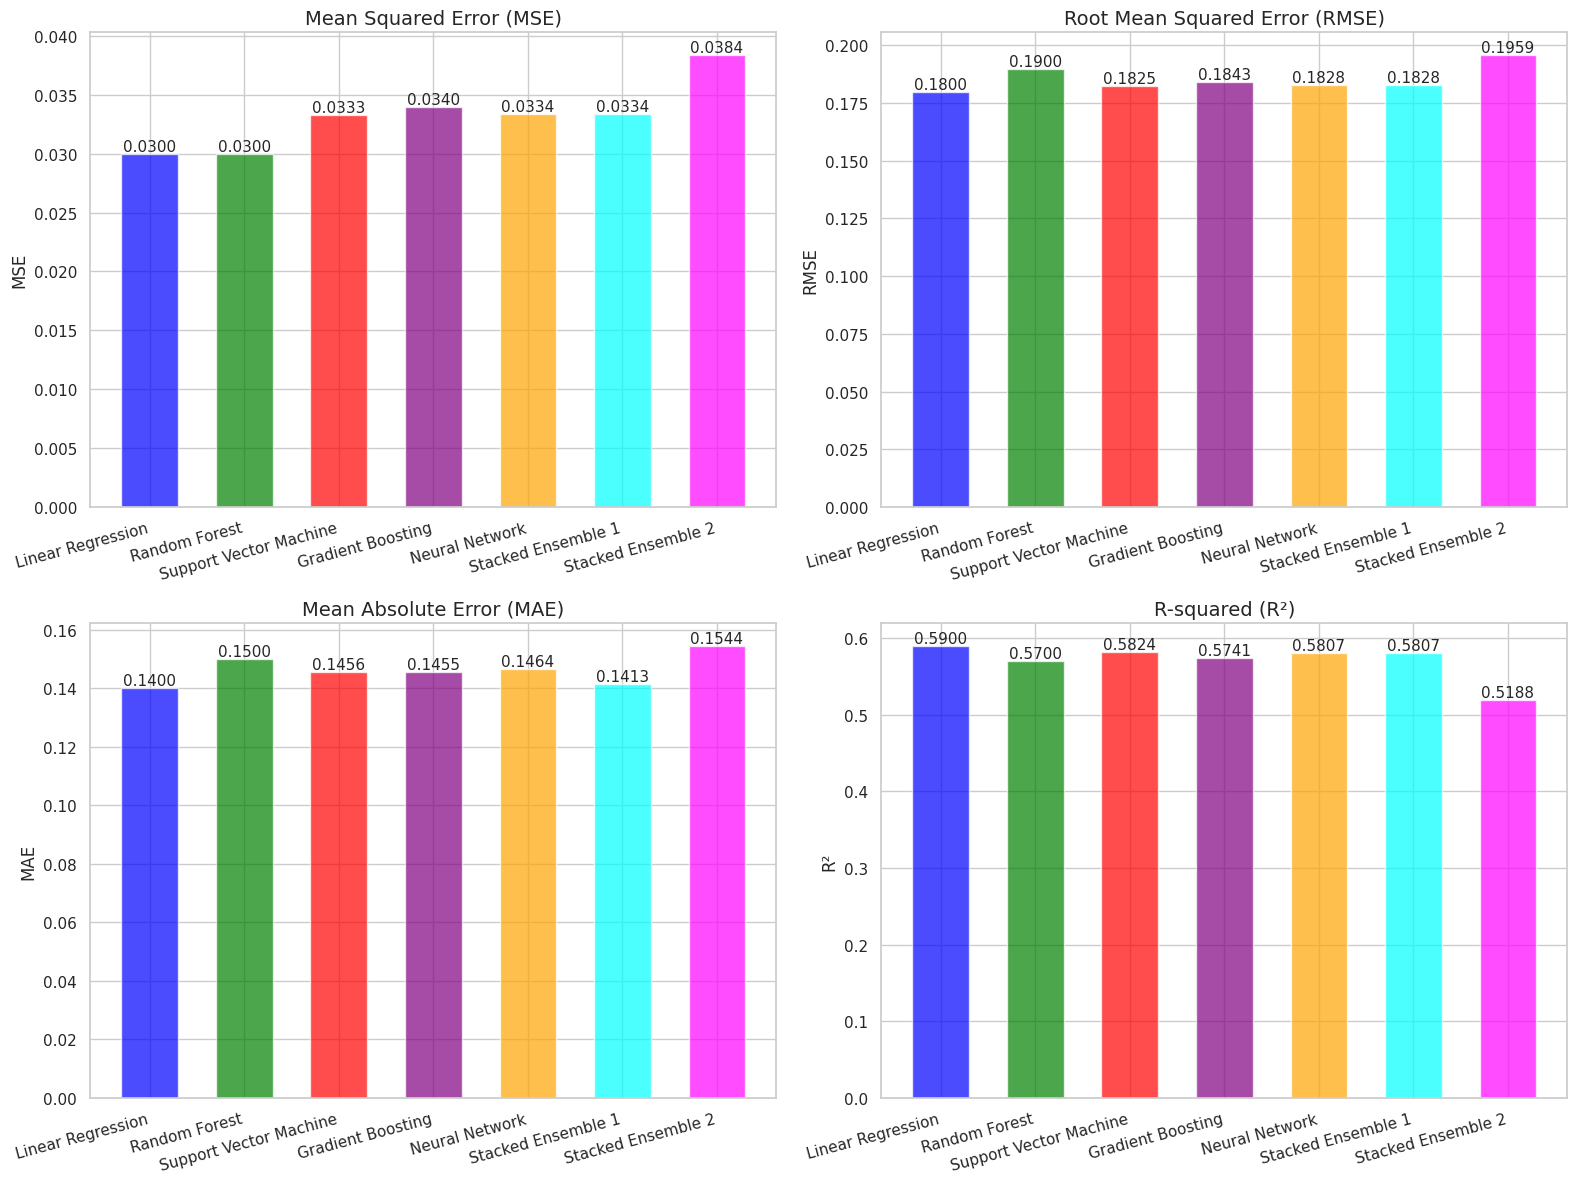

In [21]:
algorithms = [
    "Linear Regression",
    "Random Forest",
    "Support Vector Machine",
    "Gradient Boosting",
    "Neural Network",
    "Stacked Ensemble 1",
    "Stacked Ensemble 2"
]

mse = [0.03, 0.03, 0.0333, 0.0340, 0.0334, 0.0334, 0.0384]
rmse = [0.18, 0.19, 0.1825, 0.1843, 0.1828, 0.1828, 0.1959]
mae = [0.14, 0.15, 0.1456, 0.1455, 0.1464, 0.1413, 0.1544]
r2 = [0.59, 0.57, 0.5824, 0.5741, 0.5807, 0.5807, 0.5188]

bar_width = 0.6

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

metrics = [mse, rmse, mae, r2]
titles = [
    "Mean Squared Error (MSE)",
    "Root Mean Squared Error (RMSE)",
    "Mean Absolute Error (MAE)",
    "R-squared (R²)"
]
ylabels = ["MSE", "RMSE", "MAE", "R²"]

for i, ax in enumerate(axes.flat):
    bars = ax.bar(algorithms, metrics[i], color=['blue', 'green', 'red', 'purple', 'orange', 'cyan', 'magenta'], alpha=0.7, width=bar_width)
    ax.set_title(titles[i], fontsize=14)
    ax.set_ylabel(ylabels[i], fontsize=12)
    ax.set_xticklabels(algorithms, rotation=15, ha="right")

    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height, f'{height:.4f}', ha='center', va='bottom', fontsize=11)

plt.tight_layout()
plt.show()


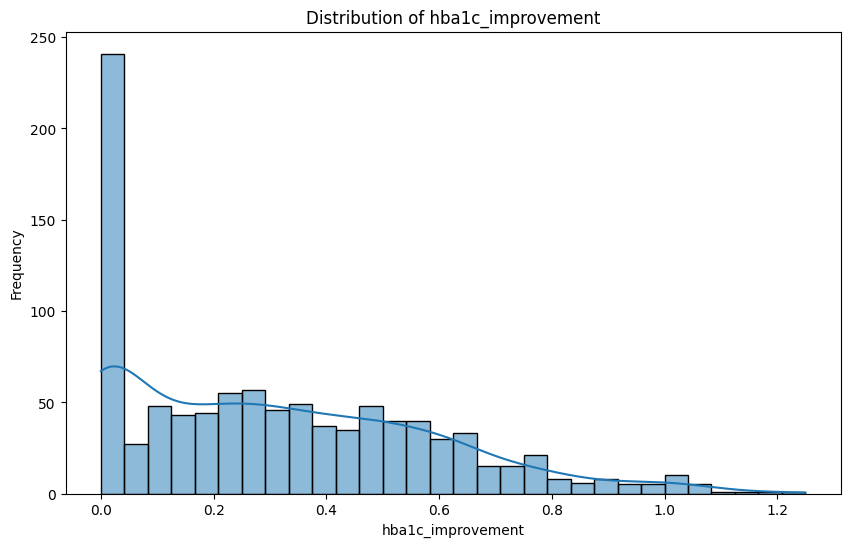

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(df["hba1c_improvement"], kde=True, bins=30)
plt.title("Distribution of hba1c_improvement")
plt.xlabel("hba1c_improvement")
plt.ylabel("Frequency")
plt.show()
